This notebook contains different models that attempt to classify hate speech from Twitter. It was built as part of this research: https://arxiv.org/pdf/1703.04009.pdf

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\xelor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xelor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('../data/twitter-hate-speech2.csv', encoding='latin-1')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
X=df['tweet']
y=df['class']

sss = StratifiedShuffleSplit(n_splits=1, test_size=.15, random_state=0) #TODO: Coordinate random seed between notebooks
train_index, test_index = next(sss.split(X,y))

X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test = y.iloc[test_index]

# Feature Engineering:

In [5]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class PosTfidfVectorizer(BaseEstimator, TransformerMixin):
    """Get POS tags for tweets and transform via tfidf"""
    
    def __init__(self):
        self._pos_vectorizer = TfidfVectorizer(
            tokenizer=None,
            lowercase=False,
            preprocessor=None,
            ngram_range=(1, 3),
            stop_words=None,
            use_idf=False,
            smooth_idf=False,
            norm=None,
            decode_error='replace',
            max_features=5000,
            min_df=5,
            max_df=0.75,
            )    
    
    def _preprocess(self, X):
        tweet_tags = []
        for t in X:
            tokens = basic_tokenize(preprocess(t))
            tags = nltk.pos_tag(tokens)
            tag_list = [x[1] for x in tags]
            tag_str = " ".join(tag_list)
            tweet_tags.append(tag_str)
        return tweet_tags
    
    def fit(self, X, y=None):
        tweet_tags = self._preprocess(X)
        self._pos_vectorizer.fit(X)
        
        return self
    
    def transform(self, X, y=None):
        tweet_tags = self._preprocess(X)
        return self._pos_vectorizer.transform(X)

In [7]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

class SentimentVectorizer(BaseEstimator, TransformerMixin): 

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return get_feature_array(X)

In [8]:
from sklearn.pipeline import FeatureUnion, Pipeline

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )
pos_vectorizer = PosTfidfVectorizer()
sentiment_vectorizer = SentimentVectorizer()

model = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', vectorizer),
        ('pos_tfidf', pos_vectorizer),
        ('sentiment', sentiment_vectorizer)
    ])),
    ('feature_selector', SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01, solver='liblinear'))),
    ('model', LogisticRegression(class_weight='balanced', penalty='l2', C=0.01, solver='liblinear'))
])

# Running the model:

In [9]:
model.fit(X_train,y_train)

c:\Users\xelor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\xelor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(decode_error='replace',
                                                                 max_df=0.75,
                                                                 max_features=10000,
                                                                 min_df=5,
                                                                 ngram_range=(1,
                                                                              3),
                                                                 norm=None,
                                                                 preprocessor=<function preprocess at 0x000001EE4DDC28E0>,
                                                                 smooth_idf=False,
                                                                 stop_words=['i',
                                                                             'me',
                                                                             'my',
                                                                             'myself',
                                                                             'we',
                                                                             'our',
                                                                             'ours',
                                                                             'ourselves',
                                                                             'you',
                                                                             "you're",
                                                                             "you've",
                                                                             "you'll",
                                                                             "you'd...
                                                                             'itself', ...],
                                                                 tokenizer=<function tokenize at 0x000001EE4DDC27A0>)),
                                                ('pos_tfidf',
                                                 PosTfidfVectorizer()),
                                                ('sentiment',
                                                 SentimentVectorizer())])),
                ('feature_selector',
                 SelectFromModel(estimator=LogisticRegression(C=0.01,
                                                              class_weight='balanced',
                                                              penalty='l1',
                                                              solver='liblinear'))),
                ('model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    solver='liblinear'))])

In [10]:
y_preds = model.predict(X_test)

# Evaluating the results on the test set:

In [13]:
report = classification_report( y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.39      0.36       214
           1       0.94      0.89      0.92      2879
           2       0.73      0.88      0.80       625

    accuracy                           0.86      3718
   macro avg       0.67      0.72      0.69      3718
weighted avg       0.87      0.86      0.86      3718



<Axes: >

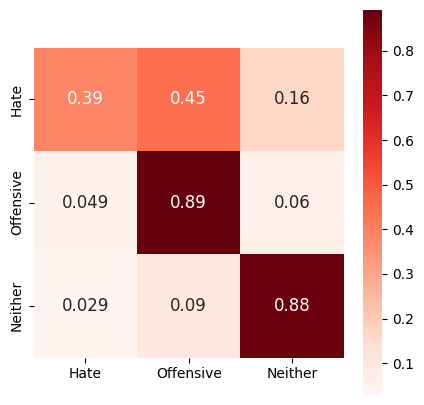

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = confusion_matrix[i, :] / \
        float(confusion_matrix[i, :].sum())
names = ['Hate', 'Offensive', 'Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={"size": 12}, square=True, cmap="Reds")

In [15]:
import joblib

# Save the trained model
joblib.dump(model, '../model/multiclass_model.pkl')  

print("\nModel saved !")



Model saved !


In [22]:
# Example new tweets for prediction
new_tweets = [
    "I love this product! It's amazing! #BestProductEver",
    "Horrible customer service, never again #Disappointed",
    "This is a neutral statement with no offense.",
    "Fuck you nigger you should die",
    "this faggot is getting on my nerves",
    "Fuck you man"
]

# Assuming processed_tweets is a list of preprocessed tweets (preprocessed using your 'preprocess' function)
processed_tweets = [preprocess(tweet) for tweet in new_tweets]

In [ ]:
# Perform inference on the new data
predictions = model.predict(processed_tweets)

# If you want the probabilities, you can use predict_proba()
prediction_probabilities = model.predict_proba(processed_tweets)

# Define class names based on your dataset's class (0 = Hate Speech, 1 = Offensive Language, 2 = Neither)
class_names = ['Hate Speech', 'Offensive Language', 'Neither']

# Print out the predictions along with their class names
print("Predictions (Class Names):")
for tweet, prediction in zip(new_tweets, predictions):
    print(f"Tweet: {tweet}")
    print(f"Prediction: {class_names[prediction]}")
    print("="*40)

# Print the prediction probabilities for each tweet and class
print("\nPrediction Probabilities:")
for tweet, probs in zip(new_tweets, prediction_probabilities):
    print(f"Tweet: {tweet}")
    for i, prob in enumerate(probs):
        print(f"  Class '{class_names[i]}': Probability = {prob:.4f}")
    print("="*40)

Predictions (Class Names):
Tweet: I love this product! It's amazing! #BestProductEver
Prediction: Neither
Tweet: Horrible customer service, never again #Disappointed
Prediction: Neither
Tweet: This is a neutral statement with no offense.
Prediction: Neither
Tweet: Fuck you nigger you should die
Prediction: Hate Speech
Tweet: this faggot is getting on my nerves
Prediction: Hate Speech
Tweet: Fuck you man
Prediction: Offensive Language

Prediction Probabilities:
Tweet: I love this product! It's amazing! #BestProductEver
  Class 'Hate Speech': Probability = 0.1425
  Class 'Offensive Language': Probability = 0.2221
  Class 'Neither': Probability = 0.6354
Tweet: Horrible customer service, never again #Disappointed
  Class 'Hate Speech': Probability = 0.1309
  Class 'Offensive Language': Probability = 0.1573
  Class 'Neither': Probability = 0.7117
Tweet: This is a neutral statement with no offense.
  Class 'Hate Speech': Probability = 0.0347
  Class 'Offensive Language': Probability = 0.3172

In [24]:
probs

array([0.38938815, 0.59135365, 0.0192582 ])

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import pandas as pd

class_names = ['Hate Speech', 'Offensive Language', 'Neither']

app = Flask(__name__)
CORS(app, resources={r"/*": {"origins": "*"}})  # Allow CORS for all routes

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        new_tweets = data.get("tweets", [])

        if not new_tweets:
            return jsonify({"error": "No tweets provided"}), 400
        
        # Preprocess the tweets
        processed_tweets = [preprocess(tweet) for tweet in new_tweets]
        
        # Make predictions
        predictions = model.predict(processed_tweets)
        prediction_probabilities = model.predict_proba(processed_tweets)
        
        # Create response with predictions and probabilities
        response = []
        for tweet, prediction, probs in zip(new_tweets, predictions, prediction_probabilities):
            response.append({
                "tweet": tweet,
                "prediction": class_names[prediction],
                "probabilities": {class_names[i]: float(prob) for i, prob in enumerate(probs)}
            })
        
        return jsonify(response)
    
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route('/upload', methods=['POST'])
def upload_file():
    try:
        if 'file' not in request.files:
            return jsonify({"error": "No file part"}), 400
        
        file = request.files['file']
        
        if file.filename == '':
            return jsonify({"error": "No selected file"}), 400

        df = pd.read_csv(file, on_bad_lines='skip')
        preview = df.head().to_dict(orient='records')
        column_names = df.columns.tolist()
        
        return jsonify({
            "preview": preview,
            "columns": column_names
        })
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return jsonify({"error": "Something went wrong. Please check the server logs for more details."}), 500

@app.route('/process_file', methods=['POST'])
def process_file():
    try:
        # Ensure the incoming request contains the necessary data
        data = request.get_json()
        file_data = data.get('fileData')
        column = data.get('column')
        
        if not file_data or not column:
            return jsonify({"error": "Missing file data or column name"}), 400

        # Process the file data here (e.g., applying predictions to each tweet)
        predictions = []
        for row in file_data:
            tweet = row.get(column)
            if tweet:
                # Preprocess the tweet
                processed_tweet = preprocess(tweet)
                
                # Apply the model prediction
                prediction = model.predict([processed_tweet])
                prediction_probs = model.predict_proba([processed_tweet])
                
                # Get the predicted class and probabilities
                predicted_class = class_names[prediction[0]]
                probabilities = {class_names[i]: float(prob) for i, prob in enumerate(prediction_probs[0])}
                
                predictions.append({
                    "tweet": tweet,
                    "prediction": predicted_class,
                    "probabilities": probabilities
                })
                
        return jsonify(predictions)
    
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
